In [1]:
import sys
sys.path.append('../scripts/')
from dp_policy_agent import *
import copy

In [2]:
class StateInfo: 
    def __init__(self, action_num, epsilon=0.3):
        self.action_values = np.zeros(action_num)
        self.epsilon = epsilon
        
    def greedy(self):
        return np.argmax(self.action_values)
    
    def epsilon_greedy(self, epsilon):
        if random.random() < epsilon:
            return random.choice(range(len(self.action_values)))
        else:
            return self.greedy()
    
    def get_action(self):
        return self.epsilon_greedy(self.epsilon)
    
    def get_state_value(self):
        return max(self.action_values)

In [3]:
class QAgent(PuddleIgnoreAgent):  
    def __init__(self, time_interval, particle_pose, envmap, goal, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, puddle_coef=100, alpha=0.5):    #alpha追加
        
        super().__init__(time_interval, particle_pose, envmap, goal, particle_num, motion_noise_stds)
        
        ###DynamicProgrammingから持ってくる###
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.goal = goal
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
        ###PuddleWorldから水たまりとゴールの情報をもらうための変数###
        self.puddle_depth = 0.0
        self.in_goal = False
        self.final_value = 0.0
        
        ###PuddleIgnorePolicyの方策と価値関数の読み込み###
        self.actions, self.action_value_function = self.set_action_value_function()
        
        self.s, self.a, self.r, self.prev_q, self.after_q = None, None, None, 0, 0 #追加
        self.alpha = alpha #追加

    def set_action_value_function(self): #二つのファイルを読んで行動のリストと行動価値関数を初期化
        policy = np.zeros(np.r_[self.index_nums,2])
        for line in open("puddle_ignore_policy.txt", "r"): #方策のファイルを読み込む
            d = line.split()
            policy[int(d[0]), int(d[1]), int(d[2])] = [float(d[3]), float(d[4])]
        
        actions = list(set([tuple(policy[i]) for i in self.indexes])) #行動のリスト（前進、左回転、右回転のリストに）
        action_num = len(actions) #行動のリストの要素数
        
        q = {}
        for line in open("puddle_ignore_values.txt", "r"): #価値のファイルを読み込む
            d = line.split()
            index, value = (int(d[0]), int(d[1]), int(d[2])), float(d[3]) #インデックスをタプル、値を数字に
            q[index] = StateInfo(action_num) #StateInfoオブジェクトを割り当てて初期化
            
            for i, a in enumerate(actions): #方策の行動価値を価値のファイルに書いてある値に。そうでない場合はちょっと引く
                q[index].action_values[i] = value if tuple(policy[index]) == a else value - 0.1
                
        return actions, q
    
    def policy(self, pose):
        index = np.floor((pose - self.pose_min)/self.widths).astype(int)
        
        index[2] = (index[2] + self.index_nums[2]*1000)%self.index_nums[2]
        for i in [0,1]:
            if index[i] < 0: index[i] = 0
            elif index[i] >= self.index_nums[i]: index[i] = self.index_nums[i] - 1
            
        s = tuple(index) #Q学習の式で使う記号に変更
        a = self.action_value_function[s].get_action()
        return s, a
        
    def decision(self, observation=None):
        self.r = -self.time_interval - self.time_interval * self.puddle_coef * self.puddle_depth #前回の状態遷移の報酬
        
        self.mcl.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.mcl.observation_update(observation)
        s_dash, a_next = self.policy(self.mcl.ml_pose) #MCLの結果から前回の状態遷移のs'と次の行動（max_a'のa'ではないことに注意）を観測
        
        if self.s != None:
            next_q = self.action_value_function[s_dash].get_state_value()
            self.prev_q = self.action_value_function[self.s].action_values[self.a]
            
            self.action_value_function[self.s].action_values[self.a] = self.alpha*self.action_value_function[self.s].action_values[self.a] \
                                                                                               + (1.0 - self.alpha)*(self.r + next_q)
                
            self.after_q = self.action_value_function[self.s].action_values[self.a]
        
        self.s, self.a = s_dash, a_next #今の状態と行動対を次の状態遷移元にセット
        self.prev_nu, self.prev_omega = self.actions[a_next]
        return self.actions[a_next]
    
    def draw(self, ax, elems): 
        super().draw(ax, elems)
        elems.append(ax.text(-4, -4.5, "reward:" + str(self.r), fontsize=8))
        elems.append(ax.text(-1.5, -4.5, "Q delta:" + str(self.after_q - self.prev_q), fontsize=8))

In [4]:
class EndlessPuddleRobot(PuddleRobot): ###q5endlesspr
    def __init__(self, time_interval, pose, **kwargs): 
        super().__init__(time_interval, pose, **kwargs)
        
        self.init_pose = copy.copy(pose)
        self.init_agent = copy.deepcopy(self.agent)
        
        self.file = open("evaluations.txt", "w")
        
    def one_step(self, time_interval):
        if self.in_goal or abs(self.pose[0]) > 4.0 or abs(self.pose[1]) > 4.0:
            self.file.write(str(self.total_reward+self.final_value) + "\n")
            self.file.flush()
            
            self.pose = copy.copy(self.init_pose)
            self.total_reward = 0.0
            self.final_value = 0.0
            self.in_goal = False
            
            ref = self.agent.action_value_function
            self.agent = copy.deepcopy(self.init_agent)
            self.agent.action_value_function = ref
            return
        
        super().one_step(time_interval)

<IPython.core.display.Javascript object>


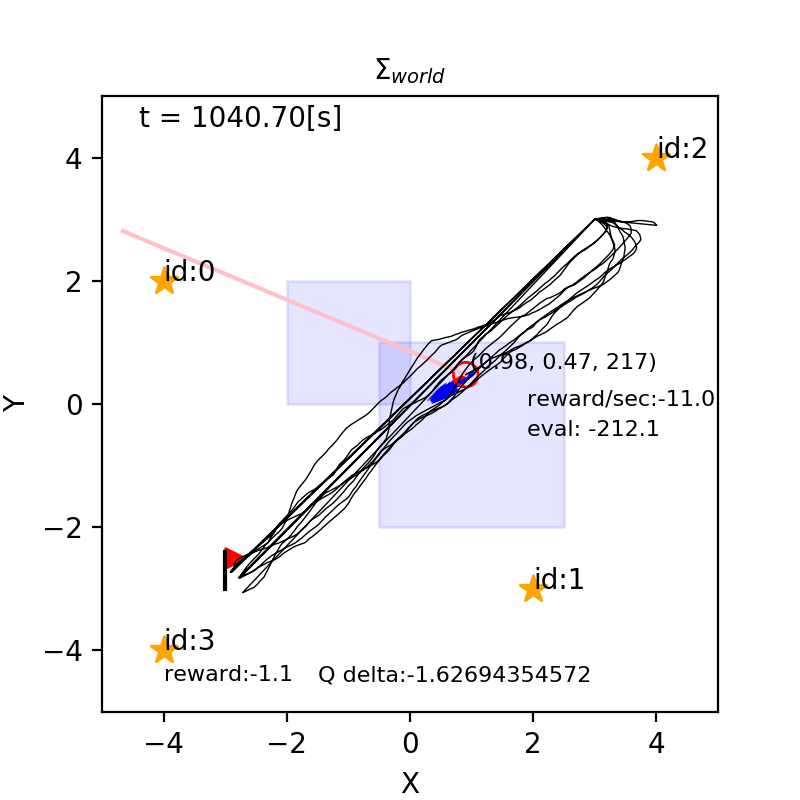

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = PuddleWorld(10000000, time_interval)  #長めにアニメーション時間をとる

    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(4,4))
    m.append_landmark(Landmark(-4,-4)) #追加（ゴール方向にランドマークがないので）
    world.append(m)
    
    ###ゴールの追加###
    goal = Goal(-3,-3)
    world.append(goal)
    
    ###水たまりの追加###
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1))

    ###ロボットを1台登場させる###
    init_pose = np.array([3, 3, 0]).T
   # init_pose = np.array([-2, -2, 0]).T
    qa = QAgent(time_interval, init_pose, m, goal)  
    r = EndlessPuddleRobot(time_interval, init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0),
              agent=qa, color="red", bias_rate_stds=(0,0))

    world.append(r)
    
    world.draw()
    #r.one_step(0.1) #デバッグ時

<IPython.core.display.Javascript object>


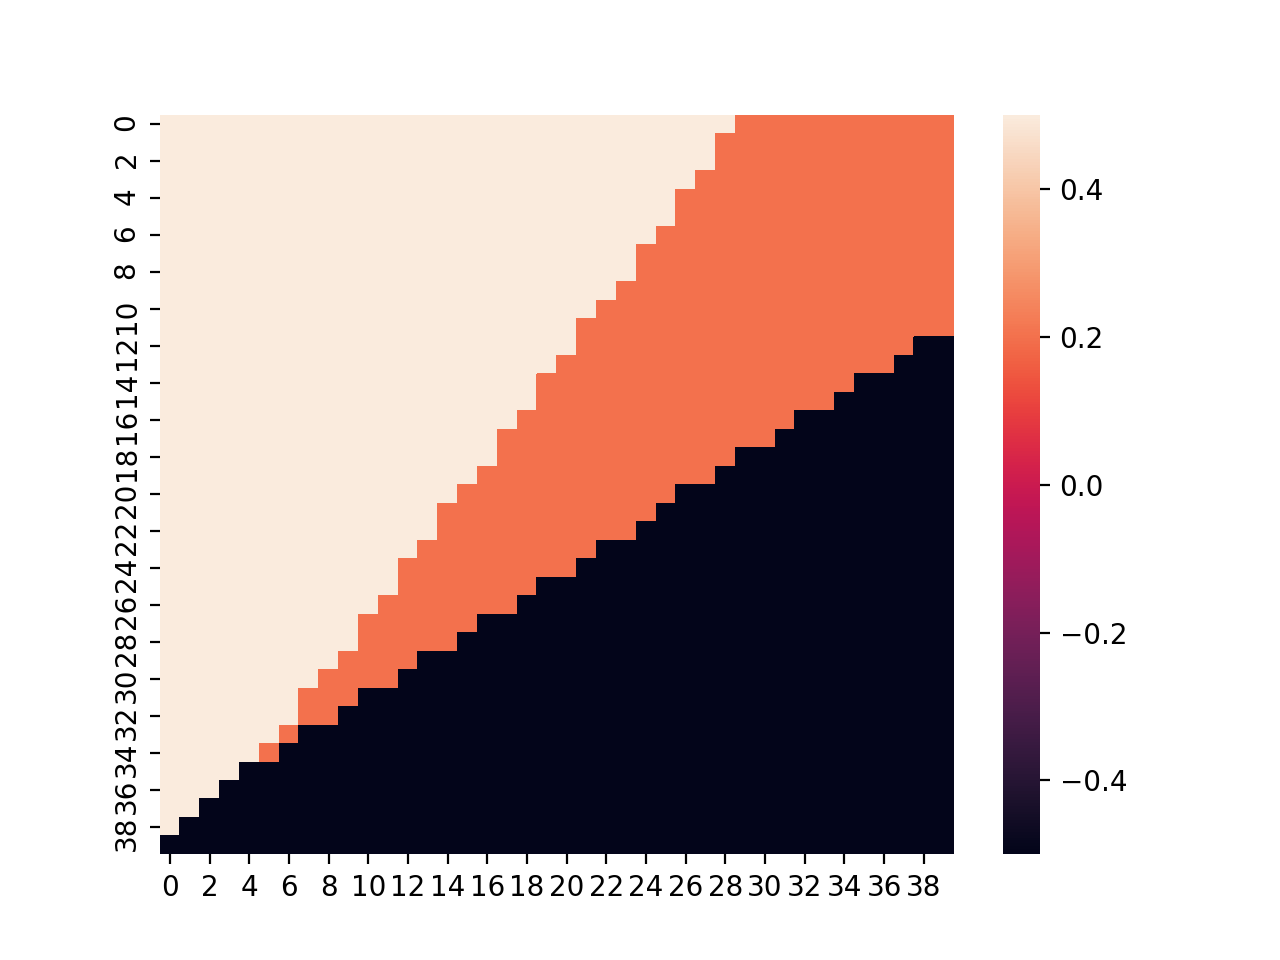

In [6]:
p = np.zeros(r.agent.index_nums[0:2])
for x in range(r.agent.index_nums[0]):
    for y in range(r.agent.index_nums[1]):
        a = r.agent.action_value_function[(x,y,22)].greedy()
        p[x,y] = r.agent.actions[a][0] + r.agent.actions[a][1]
        
import seaborn as sns   
sns.heatmap(np.rot90(p), square=False)
plt.show()